# Traditional approach

In this tutorial, we'll simulate a simple 2D localization problem as per the figure below. We'll assume that we have a robot following a simple body-frame-velocity model, which has access to noisy measurements of its forward velocity $v$ and angular velocity $\omega$. In addition, this robot will have a time-of-flight sensor that gives it range measurements to a few known landmarks in the environment. 

INSERT DIAGRAM HERE


## Define the State
The first step is to define the state of the robot. We'll start with a more traditional approach and define the state of the robot to be a vector of the form $\mathbf{x} = [\theta, x, y ]^T$, where $x$ and $y$ are the robot's position in the world and $\theta$ is its orientation. We'll also define the control inputs to be $\mathbf{u} = [\omega, v]^T$, the robot's forward and angular velocity. The process (motion) model of the robot is then given by:

$$
\begin{aligned}
    \dot{\theta} &= \omega,\\
    \dot{x} &= v \cos(\theta), \\
    \dot{y} &= v \sin(\theta). 
\end{aligned}
$$

However, this is in continuous time, and we need to discretize it to use it in a filter. For now, we'll use the simple Euler discretization method, which gives us the following discrete-time process model:

$$
\begin{aligned}
    \theta_{k+1} &= \theta_k + \omega_k \Delta t, \\
    x_{k+1} &= x_k + v_k \cos(\theta_k) \Delta t, \\
    y_{k+1} &= y_k + v_k \sin(\theta_k) \Delta t.
\end{aligned}
$$

Lets now code up our state and process model using navlie's framework. Since our state is just a regular 3x1 vector, we can use a standard type from the built-in library: `navlie.lib.VectorState` 


In [21]:
import numpy as np
np.random.seed(0)
import navlie as nav
from navlie.lib import VectorState

x = VectorState([0, 0, 0], stamp=0.0)
print(x)

VectorState(stamp=0.0, dof=3, state_id=None)
    [0. 0. 0.]


The `VectorState` is a subclass of the abstract `State` class in navlie, which is one of the core primitive types. The value of the state is stored as a numpy array, and can be accessed directly through `x.value`. 


## Define the Process Model
For the process model, we'll choose to define our own from scratch here. Process models in navlie *must* inherit from the abstract `navlie.ProcessModel` class and implement the `evaluate` and either the `input_covariance` or `covariance` methods.

In [22]:
from navlie.lib import VectorInput

Q = np.eye(2) * 0.1**2 # Input noise covariance with 0.1 m/s of standard deviation

class WheeledRobot(nav.ProcessModel):
    def evaluate(self, x: VectorState, u: nav.VectorInput, dt: float) -> VectorState:
        x_next = x.copy()
        x_next.value[0] += u.value[0] * dt
        x_next.value[1] += u.value[1] * dt * np.cos(x.value[0])
        x_next.value[2] += u.value[1] * dt * np.sin(x.value[0])
        return x_next

    def input_covariance(self, x: VectorState, u: VectorInput, dt: float) -> np.ndarray:
        return Q
    
process_model = WheeledRobot() # instantiate it

The methods in navlie process models must always accept the arguments shown above: a `State` object, an `Input` object, and a float `dt`. The `evaluate` method must always return a valid (i.e. subclass of a) `State` object, and the `input_covariance` method must always return a square numpy array. There are more optional methods that can be implemented for performance reasons, but we will cover those later.

## Define the Measurement Model(s)
Moving on to the measurement model, if $\mathbf{r}_a = [x,y]^T$ denotes the position vector of the robot resolved in the world frame, and $\mathbf{\ell}^{(i)}_{a} \in \mathbb{R}^2$ is the 2 x 1 position vector of landmark $i$, then the measurement model for each landmark is simply 

$$ 
y_i = ||\mathbf{r}_a - \mathbf{\ell}^{(i)}_{a}||
$$

In navlie, measurement models must be implemented in a similar way to process models: inherit from the `navlie.MeasurementModel` abstract class, and then implement the `evaluate` and `covariance` methods. Here's an example for this problem:

In [23]:
class RangeToLandmark(nav.MeasurementModel):
    def __init__(self, landmark_position: np.ndarray):
        self.landmark_position = landmark_position

    def evaluate(self, x: VectorState) -> np.ndarray:
        return np.linalg.norm(x.value[1:] - self.landmark_position)
    
    def covariance(self, x: VectorState) -> np.ndarray:
        return 0.1**2
    
landmarks = np.array([[1, 1], [1, 2], [2, 2], [2, 1]])
meas_models = [RangeToLandmark(landmark) for landmark in landmarks]

## (Simulation only) Generate fake data

The next step is to generate some fake data for our simulation (although navlie is also compatible with real data). To do this, we will use the `DataGenerator` class which is used as follows

In [24]:
dg = nav.DataGenerator(
    process_model=process_model,                  # process model to use
    input_func=lambda t, x: np.array([0.3, 0.5]), # a callable that specifies the input values over time
    input_covariance= Q,                          # numpy array or callable that specifies the input covariance over time
    input_freq=50,                                # the frequency (Hz) at which the input is sampled (and the process model integrated)
    meas_model_list=meas_models,                  # a list of measurement models to use
    meas_freq_list=[10, 10, 10, 10]               # corresponding measurement frequencies (Hz)
)

state_data, input_data, meas_data = dg.generate(x, start=0, stop=30, noise=True)

print(state_data[0])
print(input_data[0])
print(meas_data[0])

VectorState(stamp=0.0, dof=3, state_id=None)
    [0. 0. 0.]
VectorInput(stamp=0.0, state_id=None)
    [0.4867558  0.40227221]
Measurement(stamp=0.0, state_id=None) of RangeToLandmark
    1.5906187969698615


The output of the `DataGenerator.generate` method is three lists: a list of ground-truth `State` objects, a list of `Input` objects, and a list of `Measurement` objects, with the input/measurement lists possibly being corrupted by random noise if the `noise=True` flag is set. Each item in these lists correspond to different points in time. We can plot the trajectory as follows

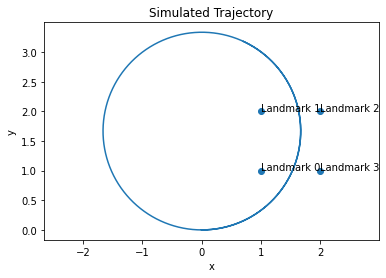

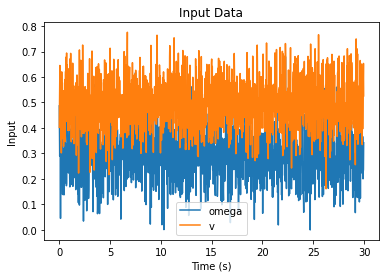

In [25]:
import matplotlib.pyplot as plt

# Plot the state trajectory
pos = np.array([state.value[1:] for state in state_data])
plt.plot(pos[:, 0], pos[:, 1])
plt.scatter(landmarks[:, 0], landmarks[:, 1])
# add labels
for i, landmark in enumerate(landmarks):
    plt.annotate(f"Landmark {i}", landmark)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Simulated Trajectory")
plt.axis("equal")


# Plot the input data
plt.figure()
u_array = np.array([u.value for u in input_data])
u_stamps = np.array([u.stamp for u in input_data])
plt.plot(u_stamps, u_array[:, 0], label="omega")
plt.plot(u_stamps, u_array[:, 1], label="v")
plt.xlabel("Time (s)")
plt.ylabel("Input")
plt.title("Input Data")
plt.legend()
plt.show()


## Run a filter!

Finally, lets run an extended Kalman filter on this data to get a state estimate that uses only the noisy measurements. In the below filter, we instantiate the `nav.ExtendedKalmanFilter` to use on our data, and looping over the input measurements while also calling the correction step whenever a measurement occurs.

In [26]:
# First, define the filter
kalman_filter = nav.ExtendedKalmanFilter(process_model)

# You can try other filters too!
# kalman_filter = nav.UnscentedKalmanFilter(process_model)
# kalman_filter = nav.IteratedKalmanFIlter(process_model)

P0 = np.diag([0.1**2, 1**2, 1**2])  # Initial covariance
x = nav.StateWithCovariance(x, P0)  # Estimate and covariance in one container

meas_idx = 0
y = meas_data[meas_idx]
estimates = []
for k in range(len(input_data) - 1):
    u = input_data[k]

    # Fuse any measurements that have occurred.
    while y.stamp < input_data[k + 1].stamp and meas_idx < len(meas_data):
        x = kalman_filter.correct(x, y, u)

        # Load the next measurement
        meas_idx += 1
        if meas_idx < len(meas_data):
            y = meas_data[meas_idx]

    # Predict until the next input is available
    dt = input_data[k + 1].stamp - x.state.stamp
    x = kalman_filter.predict(x, u, dt)

    estimates.append(x.copy())

The filters in navlie are all designed to be *stateless*: this means that the actual state estimate is stored externally to the filter objects, in this case in a container called `StateWithCovariance`. Although this adds a slight burden on the user, it has the advantage of being more transparent, and also providing the ability to combine different filters in the same loop! For example, you could use an EKF for the prediction, but a UKF for the correction, or even to use different filters for different measurement models!


Once estimates have been obtained, we will often be interested in evaluating the performance. The `GaussianResultList` object is a useful container for evaluating the quality of the state estimates when ground truth data is available. It calculates useful metrics such as raw error, Mahalanobis distance, and normalized estimation error squared (NEES). 

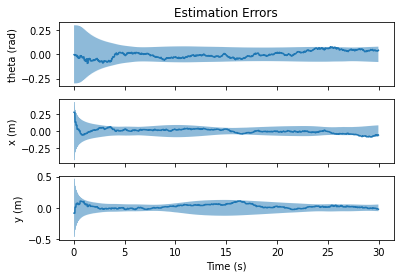

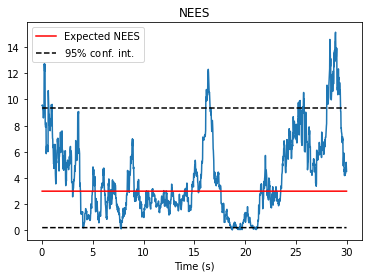

In [27]:
results = nav.GaussianResultList.from_estimates(estimates, state_data)
# results.nees 
# results.three_sigma
# results.error
# results.md # mahalanobis distance
# # and more...

# Some plotting functions that work directly with GaussianResultList
fig, axs = nav.plot_error(results)
axs[0].set_title("Estimation Errors")
axs[0].set_ylabel("theta (rad)")
axs[1].set_ylabel("x (m)")
axs[2].set_ylabel("y (m)")
axs[2].set_xlabel("Time (s)")

fig, ax = nav.plot_nees(results)
ax.set_title("NEES")
ax.set_xlabel("Time (s)")
plt.show()

As a final note, `GaussianResultList` will invoke the `State.minus` method of the state objects to calculate the error. As we will see next, this allows us to implement a custom measure of error, when it might not make sense to directly subtract two of our state objects.